In [1]:
import tensorflow as tf

import numpy as np
import IPython.display as display
import PIL.Image as Image

import matplotlib as mpl

## Download image

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

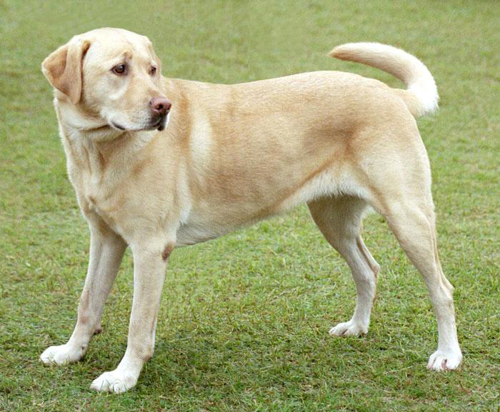

In [35]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(image):
    """de-process image.
    Args:
        image: values range [-1, 1]
    """
    img = 255 * (image + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## Prepare the feature extraction model

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

The InceptionV3 architecture is quite large (for a graph of the model architecture see TensorFlow's research repo). For DeepDream, the layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Using different layers will result in different dream-like images. Deeper layers respond to higher-level features (such as eyes and faces), while earlier layers respond to simpler features (such as edges, shapes, and textures). Feel free to experiment with the layers selected below, but keep in mind that deeper layers (those with a higher index) will take longer to train on since the gradient computation is deeper.

In [30]:
# Maximize the activations of these layers
layer_names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

In [57]:
def calc_loss(image, model):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    image_batch = tf.expand_dims(image, 0)
    layer_activations = model(image_batch)
    # If there is only one activation output
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    # for each activation
    for act in layer_activations:
        loss = tf.reduce_mean(act)
        losses.append(loss)
        
    return tf.reduce_sum(losses)

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image.

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

In [67]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
    
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )
    
    def __call__(self, image, steps, learning_rate):
        """
        Args:
            learning_rate: learning rate, multiplied by gradients
        """
        print('Tracing')
        loss = tf.constant(0.0) # "loss" must be defined before the loop.
        # Executing `steps` times
        for step in tf.range(steps):
            with tf.GradientTape() as tape:
                # This needs gradients relative to 'image'
                # 'GradientTape' only watches `tf.Variable`s by default
                tape.watch(image)
                loss = calc_loss(image, self.model)
            
            gradients = tape.gradient(loss, image)
            # Normalize the gradients
            gradients /= tf.math.reduce_std(gradients) + 1e-8
            
            # In gradient ascent, the "loss" is maximized so that the input image increasingly "exites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            image = image + gradients * learning_rate
            image = tf.clip_by_value(image, -1, 1)

        return loss, image

In [68]:
deepdream = DeepDream(dream_model)

## Main loop

In [87]:
def run_deep_dream_simple(image, steps=100, learning_rate=0.01):
    # Convert from uint8 to the range expected by the model.
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    image = tf.convert_to_tensor(image)
    learning_rate = tf.convert_to_tensor(learning_rate)

    steps_remaining = steps
    step = 0
    while steps_remaining:
        # if remaining steps > 100, run 100 steps every time
        if steps_remaining > 100: run_steps = tf.constant(100)
        # if remaining steps <= 100, run the remaining steps
        else: run_steps = tf.constant(steps_remaining)

        steps_remaining -= run_steps
        step += run_steps
        
        loss, image = deepdream(image=image, steps=run_steps, learning_rate=learning_rate)
        
        display.clear_output(wait=True)
        result = deprocess(image)
        show(result)
        print('Step {}, Loss {}'.format(step, loss))
    
    return result

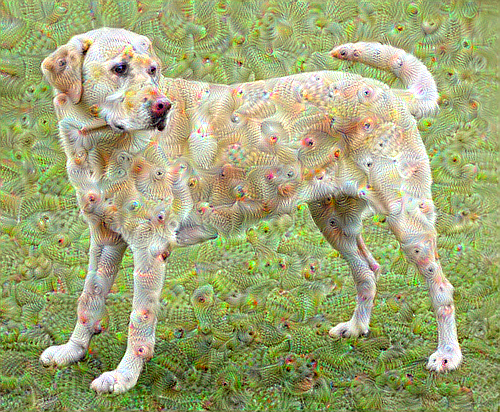

Step 100, Loss 2.3042683601379395


In [100]:
dream_image = run_deep_dream_simple(image=original_img, steps=100, learning_rate=0.01)

## Taking it up an octave

There are a few issues with this first attempt:
- The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
- The image is low resolution.
- The patterns appear like they're all happening at the same granularity.

One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.

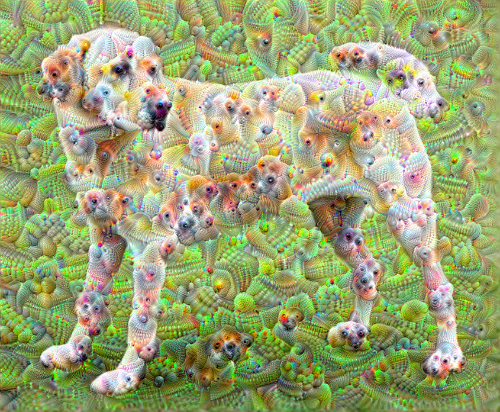

In [112]:
OCTAVE_SCALE = 1.30

image = tf.constant(np.array(original_img))
base_shape = tf.shape(image)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    # resize to larger shape
    new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE**n), tf.int32)
    image = tf.image.resize(image, new_shape).numpy()
    # run model
    image = run_deep_dream_simple(image, steps=50, learning_rate=0.01)

display.clear_output(wait=True)
# resize back to original shape
image = tf.image.resize(image, base_shape)
image = tf.image.convert_image_dtype(image/255.0, tf.uint8)
show(image)

## Optional: Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

In [124]:
def random_roll(image, maxroll):
    # randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0], shift[1]
    # axis=0 means shifting height, axis=1 means shifting width
    image_rolled = tf.roll(tf.roll(image, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, image_rolled

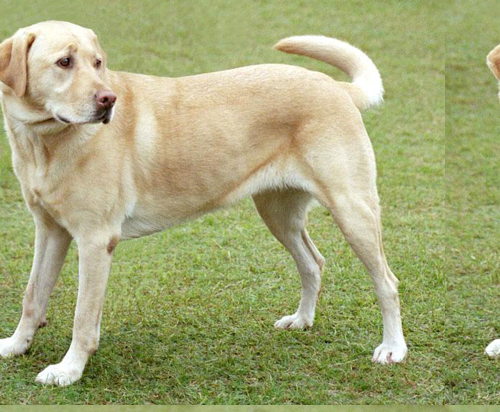

In [125]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [182]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32), # image input
            tf.TensorSpec(shape=[], dtype=tf.int32) # steps input
        )
    )
    
    def __call__(self, image, tile_size=512):
        shift_down, shift_right, image_rolled = random_roll(image, tile_size)
        
        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(image_rolled)
        
        # Skip the last tile, unless there's only one tile.
        # i.e. shift_down==heights, shift_right==width, image likes not be shifted
        heights_s = tf.range(0, image_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(heights_s), bool):
            heights_s = tf.constant([0])
        width_s = tf.range(0, image_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(width_s), bool):
            width_s = tf.constant([0])
        
        for x in heights_s:
            for y in width_s:
                # Calculate the gradients for this tile
                with tf.GradientTape() as tape:
                    # This needs gradientts relative to `image_rolled`.
                    # `GradientTape` only watches `tf.Variable`s by default.
                    tape.watch(image_rolled)

                    # Extract a tile out of the image
                    image_tile = image_rolled[x:x+tile_size, y:y+tile_size, :]
                    # Calculate loss for this tile
                    loss = calc_loss(image_tile, self.model)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, image_rolled) # [HEIGHTS, WIDTH, CHANNEL]
            
        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)
        
        # Normalize the gradients
        gradients /= tf.math.reduce_std(gradients) + 1e-8
        
        return gradients

In [183]:
get_tiled_gradients = TiledGradients(dream_model)

In [184]:
def run_deep_dream_with_octaves(image,
                                steps_per_octave=100,
                                learning_rate=0.01,
                                octaves=range(-2,3),
                                octave_scale=1.3):

    base_shape = tf.shape(image)[:-1]
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(base_shape, tf.float32) * (octave_scale**octave)
        image = tf.image.resize(image, tf.cast(new_size, tf.int32))
        
        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(image)
            image = image + gradients * learning_rate
            image = tf.clip_by_value(image, -1, 1)
            
            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(image))
                print('Octave {}, Step {}'.format(octave, step))
                
    result = deprocess(image)
    return result

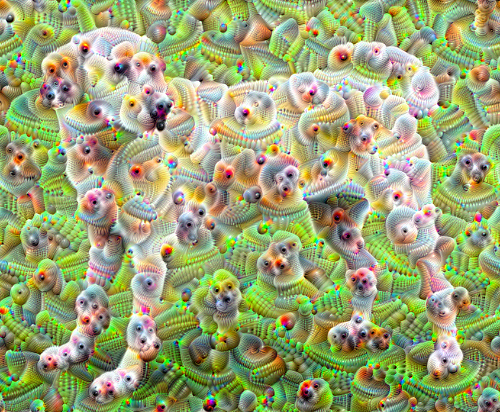

In [185]:
image = run_deep_dream_with_octaves(image=original_img, learning_rate=0.01)

display.clear_output(wait=True)
image = tf.image.resize(image, base_shape)
image = tf.image.convert_image_dtype(image/255.0, dtype=tf.uint8)
show(image)